## Import modules and data

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import mlab
import matplotlib.pyplot as plt
from patsy import dmatrices

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from datetime import datetime
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import tree

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy import stats 

import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [4]:
homer_clean = pd.read_csv('Homer_clean3.csv')
print homer_clean.shape
homer_clean.head()

(5834, 46)


,userid,path_type,multi_user_label,single_user,multiple_user,total_events,completed_count,completed_cat,not_completed_count,event_count_cat,...,pop_event_day,pop_title,pop_category,distinct_titles,title_count_cat,max_row,max_column,avg_row,avg_col,ctp
0,-9.219518e+18,"alc, pathways",Single-user,1,0,36,25,med,8,medium,...,Saturday,Letter Hunt,GAM,24,high,1.0,25.0,1.0,9.0,1
1,-9.218149e+18,pathways,Single-user,1,0,5,4,low,0,low,...,Sunday,Letter Hunt,NaN,2,low,NaN,NaN,NaN,NaN,0
2,-9.217416e+18,"alc, pathways",Single-user,1,0,59,36,med,21,high,...,Friday,"Make the Letters: A,a",NaN,39,high,20.0,16.0,3.0,4.0,0
3,-9.217257e+18,"alc, pathways",Single-user,1,0,126,111,very_high,14,very high,...,Thursday,Swimmy,RAS,87,very high,21.0,15.0,4.0,4.0,1
4,-9.212743e+18,"alc, pathways",Multiple-user,0,1,144,105,very_high,35,very high,...,Tuesday,The Airport,NaN,87,very high,28.0,16.0,2.0,3.0,1


## Data cleaning / prep for feature selection: binarize variables, impute missing data

In [5]:
homer_clean.columns.values

array(['userid', 'path_type', 'multi_user_label', 'single_user',
       'multiple_user', 'total_events', 'completed_count',
       'completed_cat', 'not_completed_count', 'event_count_cat',
       'device_cat', 'ipad_event', 'iphone_event', 'ipod_event',
       'max_stage_complete', 'pathways_complete_rank',
       'pathways_reach_rank', 'pathways_count', 'alc_count',
       'average_age_int', 'max_stage', 'first_week', 'second_week',
       'third_week', 'distinct_weeks', 'distinct_days',
       'avg_weekly_visit', 'avg_daily_hrs', 'weekly_visit_cat',
       'max_days_into_trial', 'avg_days_from_trial', 'trial_day',
       'max_stage_num', 'avg_level', 'avg_cluster', 'avg_step',
       'pop_event_day', 'pop_title', 'pop_category', 'distinct_titles',
       'title_count_cat', 'max_row', 'max_column', 'avg_row', 'avg_col',
       'ctp'], dtype=object)

In [6]:
homer_clean.describe()

,userid,single_user,multiple_user,total_events,completed_count,not_completed_count,ipad_event,iphone_event,ipod_event,pathways_complete_rank,...,max_stage_num,avg_level,avg_cluster,avg_step,distinct_titles,max_row,max_column,avg_row,avg_col,ctp
count,5.834000e+03,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5834.000000,5263.000000,...,5281.000000,5539.000000,5281.000000,5539.000000,5834.000000,3.466000e+03,3466.000000,3459.000000,3466.000000,5834.000000
mean,2.896520e+16,0.686664,0.313336,76.456462,50.795680,22.748543,33.600103,42.673294,0.183065,450.696561,...,3.294073,2.553349,1.047340,4.024553,33.741001,-1.862770e+16,11.369013,3.195721,3.241777,0.677580
std,5.349841e+18,0.463889,0.463889,129.560791,79.699731,58.472953,103.347261,94.666740,6.184218,284.176825,...,1.188351,1.352938,0.258992,1.921381,39.809618,4.141409e+17,13.144738,2.603580,3.185256,0.467443
min,-9.219518e+18,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-9.223372e+18,0.000000,0.000000,0.000000,0.000000
25%,-4.615946e+18,0.000000,0.000000,13.000000,8.000000,3.000000,0.000000,0.000000,0.000000,251.000000,...,3.000000,2.000000,1.000000,2.000000,9.000000,2.000000e+00,3.000000,1.000000,1.000000,0.000000
50%,-3.989598e+16,1.000000,0.000000,36.000000,25.000000,8.000000,0.000000,10.000000,0.000000,351.000000,...,3.000000,2.000000,1.000000,4.000000,20.000000,5.000000e+00,7.000000,2.000000,2.000000,1.000000
75%,4.680110e+18,1.000000,1.000000,91.000000,62.000000,22.000000,21.000000,46.000000,0.000000,601.000000,...,4.000000,3.000000,1.000000,5.000000,43.000000,1.300000e+01,18.000000,4.000000,4.000000,1.000000
max,9.221033e+18,1.000000,1.000000,3416.000000,1948.000000,1578.000000,3416.000000,2615.000000,425.000000,1563.000000,...,5.000000,11.000000,4.000000,14.000000,398.000000,2.800000e+01,105.000000,27.000000,40.000000,1.000000


In [7]:
homer_clean.isna().sum()

userid                       0
path_type                    0
multi_user_label             0
single_user                  0
multiple_user                0
total_events                 0
completed_count              0
completed_cat                0
not_completed_count          0
event_count_cat              0
device_cat                   0
ipad_event                   0
iphone_event                 0
ipod_event                   0
max_stage_complete         571
pathways_complete_rank     571
pathways_reach_rank        553
pathways_count               0
alc_count                    0
average_age_int            434
max_stage                  553
first_week                   0
second_week                  0
third_week                   0
distinct_weeks               0
distinct_days                0
avg_weekly_visit             0
avg_daily_hrs                0
weekly_visit_cat             0
max_days_into_trial          0
avg_days_from_trial          0
trial_day                    0
max_stag

In [8]:
initial_vars = homer_clean[['ctp','path_type','multi_user_label','total_events','completed_count','device_cat','max_stage_complete','pathways_complete_rank',
                           'pathways_reach_rank','average_age_int','distinct_weeks','avg_weekly_visit','avg_days_from_trial','avg_level',
                           'avg_cluster','avg_step','pop_event_day','pop_category','distinct_titles','avg_row','avg_col']]

In [9]:
cat_vars = ['path_type','multi_user_label','device_cat','max_stage_complete','pop_event_day','pop_category']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(homer_clean[var],prefix=var)
    homer_clean1=initial_vars.join(cat_list)
    homer_clean1.columns = [c.replace(', ', '_') for c in homer_clean1.columns]
    initial_vars=homer_clean1
cat_vars=['path_type','multi_user_label','device_cat','max_stage_complete','pop_event_day','pop_category']
data_vars=initial_vars.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [10]:
# impute missing data with 0 -- room to improve here
cat_vars = initial_vars[to_keep].fillna(0)
cat_vars.columns.values

array(['ctp', 'total_events', 'completed_count', 'pathways_complete_rank',
       'pathways_reach_rank', 'average_age_int', 'distinct_weeks',
       'avg_weekly_visit', 'avg_days_from_trial', 'avg_level',
       'avg_cluster', 'avg_step', 'distinct_titles', 'avg_row', 'avg_col',
       'path_type_alc', 'path_type_alc_pathways', 'path_type_pathways',
       'multi_user_label_Multiple-user', 'multi_user_label_Single-user',
       'device_cat_iPad', 'device_cat_iPhone', 'device_cat_iPod',
       'max_stage_complete_A', 'max_stage_complete_B',
       'max_stage_complete_C', 'max_stage_complete_D',
       'max_stage_complete_E', 'pop_event_day_Friday   ',
       'pop_event_day_Monday   ', 'pop_event_day_Saturday ',
       'pop_event_day_Sunday   ', 'pop_event_day_Thursday ',
       'pop_event_day_Tuesday  ', 'pop_event_day_Wednesday',
       'pop_category_DTW', 'pop_category_FR', 'pop_category_GAM',
       'pop_category_RAS', 'pop_category_SON'], dtype=object)

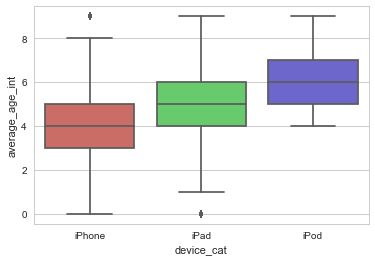

In [11]:
# exploratory analysis - look for relationships between variables 
import seaborn as sb
sb.boxplot(x='device_cat', y='average_age_int', data=homer_clean, palette='hls')

## Indicate desired customer segment: User type and Path type

In [12]:
# SELECT CUSTOMER SEGMENT FOR MODELS HERE
single = cat_vars.loc[cat_vars['multi_user_label_Single-user'] == 1].fillna(0)
single = single.loc[cat_vars['path_type_pathways'] == 1].fillna(0)
print single.shape

(1841, 40)


## Balance data using SMOTE

In [13]:
X = single.loc[:, single.columns != 'ctp']
y = single.loc[:, single.columns == 'ctp']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['ctp'])

print('length of oversampled data is',len(os_data_X))
print("Number of no CTP in oversampled data",len(os_data_y[os_data_y['ctp']==0]))
print("Number of CTP",len(os_data_y[os_data_y['ctp']==1]))
print("Proportion of no CTP data in oversampled data is ",float(len(os_data_y[os_data_y['ctp']==0])/len(os_data_X)))
print("Proportion of CTP data in oversampled data is ",float(len(os_data_y[os_data_y['ctp']==1])/len(os_data_X)))

('length of oversampled data is', 1880)
('Number of no CTP in oversampled data', 940)
('Number of CTP', 940)
('Proportion of no CTP data in oversampled data is ', 0.0)
('Proportion of CTP data in oversampled data is ', 0.0)


/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model 1: Logistic regression


In [14]:
# Feature ranking for logistic regression
data_final_vars=single.columns.values.tolist()
y=['ctp']
X=[i for i in data_final_vars if i not in y]


logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(len(rfe.support_))
print(rfe.ranking_)
test = pd.DataFrame(rfe.support_)
test.head()

39
[ 7  6 10  8  1  1  9  1  1  1  1  5 13 12 11 14  1 17  1  1  1  1  1  1
  1  1  1  1  4  1  3  2  1  1 15 16 18 19 20]


,0
0,False
1,False
2,False
3,False
4,True


In [15]:
#print features with potential predictive power
column_names = pd.DataFrame(X)
column_names = column_names.rename(columns={0: 'field'})

column_ranks = pd.concat([column_names,test], axis = 1)
column_ranks = column_ranks.rename(columns={0: 'significant'})

column_pred = column_ranks.loc[column_ranks['significant'] == True]
column_pred['field'].tolist()

['average_age_int',
 'distinct_weeks',
 'avg_days_from_trial',
 'avg_level',
 'avg_cluster',
 'avg_step',
 'path_type_pathways',
 'multi_user_label_Single-user',
 'device_cat_iPad',
 'device_cat_iPhone',
 'device_cat_iPod',
 'max_stage_complete_A',
 'max_stage_complete_B',
 'max_stage_complete_C',
 'max_stage_complete_D',
 'max_stage_complete_E',
 'pop_event_day_Friday   ',
 'pop_event_day_Saturday ',
 'pop_event_day_Tuesday  ',
 'pop_event_day_Wednesday']

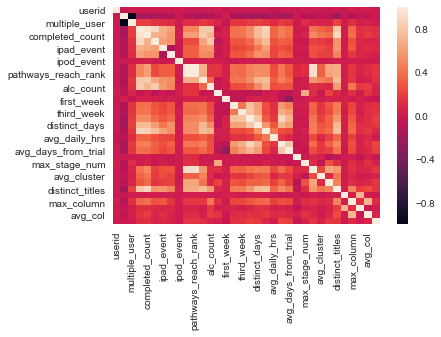

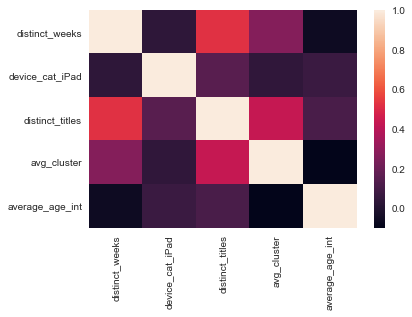

In [16]:
# Choose variables to fit model on and evaluate for correlation/multicollinearity
X = single[['distinct_weeks','device_cat_iPad','distinct_titles','avg_cluster','average_age_int']]
y = single['ctp']

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.heatmap(homer_clean.corr())
plt.show()

sns.heatmap(X.corr())
plt.show()


In [17]:
#Fit logistic model on data
classifier = LogisticRegression(random_state=0)
classifier.fit(X, y)

y_pred = classifier.predict(X)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y, y_pred)
print(confusion_matrix)

[[  26  617]
 [  35 1163]]


In [18]:
# Print accuracy scores and compare to baseline 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Baseline:', single['ctp'].mean())
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on whole set: {:.2f}'.format(logreg.score(X, y)))

('Baseline:', 0.6507332971211298)
Accuracy of logistic regression classifier on test set: 0.70
Accuracy of logistic regression classifier on train set: 0.63
Accuracy of logistic regression classifier on whole set: 0.65


In [19]:
# Print variable importances
pd.DataFrame(zip(X.columns, np.transpose(logreg.coef_)))

,0,1
0,distinct_weeks,[0.4635418208858322]
1,device_cat_iPad,[0.31429540075395984]
2,distinct_titles,[0.0003155429285413151]
3,avg_cluster,[0.18011132419066658]
4,average_age_int,[0.06824038062138127]


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.56      0.08      0.14       111
          1       0.71      0.97      0.82       258

avg / total       0.67      0.70      0.62       369



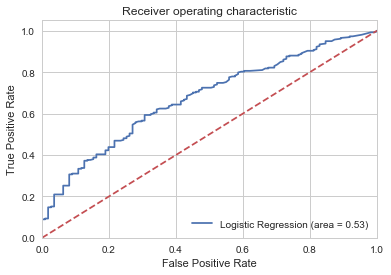

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Model 2: Random Forest

In [22]:
# Variable selection for random forest
data_final_vars=single.columns.values.tolist()
y=['ctp']
X=[i for i in data_final_vars if i not in y]

rf_exp = RandomForestRegressor()
rfe2 = RFE(rf_exp, 20)
rfe2 = rfe2.fit(os_data_X, os_data_y.values.ravel())
print(len(rfe.support_))
print(rfe.ranking_)
test = pd.DataFrame(rfe.support_)
test.head()

39
[ 7  6 10  8  1  1  9  1  1  1  1  5 13 12 11 14  1 17  1  1  1  1  1  1
  1  1  1  1  4  1  3  2  1  1 15 16 18 19 20]


,0
0,False
1,False
2,False
3,False
4,True


In [23]:
# Print names of potentially predictive variables
column_names = pd.DataFrame(X)
column_names = column_names.rename(columns={0: 'field'})

column_ranks = pd.concat([column_names,test], axis = 1)
column_ranks = column_ranks.rename(columns={0: 'significant'})

column_pred = column_ranks.loc[column_ranks['significant'] == True]
column_pred['field'].tolist()

['average_age_int',
 'distinct_weeks',
 'avg_days_from_trial',
 'avg_level',
 'avg_cluster',
 'avg_step',
 'path_type_pathways',
 'multi_user_label_Single-user',
 'device_cat_iPad',
 'device_cat_iPhone',
 'device_cat_iPod',
 'max_stage_complete_A',
 'max_stage_complete_B',
 'max_stage_complete_C',
 'max_stage_complete_D',
 'max_stage_complete_E',
 'pop_event_day_Friday   ',
 'pop_event_day_Saturday ',
 'pop_event_day_Tuesday  ',
 'pop_event_day_Wednesday']

In [24]:
# Select variables for model and output cross validation scores
X = single[['average_age_int',
 'distinct_weeks',
 'avg_row',
 'device_cat_iPad',
 'device_cat_iPhone',
 'pop_category_GAM',
 'pop_category_RAS']]
y=single['ctp']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

clf = RandomForestClassifier(n_jobs=2, n_estimators = 10, max_depth = 3,max_features=None, oob_score = True, min_samples_leaf = 20)
clf = clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)
print cv_scores
print clf.score(X, y), clf.score(X_test, y_test)
print list(zip(X, clf.feature_importances_))
print pd.crosstab(y, clf.predict(X), rownames=['Actual'], colnames=['Predicted'])

('Training Features Shape:', (1472, 7))
('Training Labels Shape:', (1472,))
('Testing Features Shape:', (369, 7))
('Testing Labels Shape:', (369,))


/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores

[0.67118644 0.64745763 0.63605442 0.65986395 0.64965986]
0.6507332971211298 0.6314363143631436
[('average_age_int', 0.1832840932201602), ('distinct_weeks', 0.6582507955095782), ('avg_row', 0.0), ('device_cat_iPad', 0.12691962793345044), ('device_cat_iPhone', 0.031545483336811134), ('pop_category_GAM', 0.0), ('pop_category_RAS', 0.0)]
Predicted     1
Actual         
0           643
1          1198


In [25]:
# Can use this to predict output for users, optional
final = single.reset_index()
proba = clf.predict_proba(X)
proba = pd.DataFrame(proba, columns = ['prob_no_ctp', 'prob_ctp'])
CTP_pred = proba[['prob_ctp']].apply(lambda x: x*100)
CTP_pred.reset_index()
CTP_pred.head()
CTP_output = pd.concat([CTP_pred,final], axis = 1)
CTP_output.head(10)

,prob_ctp,index,ctp,total_events,completed_count,pathways_complete_rank,pathways_reach_rank,average_age_int,distinct_weeks,avg_weekly_visit,...,pop_event_day_Saturday,pop_event_day_Sunday,pop_event_day_Thursday,pop_event_day_Tuesday,pop_event_day_Wednesday,pop_category_DTW,pop_category_FR,pop_category_GAM,pop_category_RAS,pop_category_SON
0,64.108086,1,0,5,4,121.0,211.0,1.0,2,3,...,0,1,0,0,0,0,0,0,0,0
1,62.327612,5,1,6,5,781.0,781.0,0.0,1,6,...,0,0,0,0,0,0,0,0,0,0
2,57.547350,15,1,1,0,0.0,111.0,6.0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,76.199402,17,0,13,5,321.0,331.0,0.0,2,7,...,0,0,0,0,0,0,0,0,0,0
4,53.986399,18,1,21,20,231.0,231.0,2.0,1,21,...,0,1,0,0,0,0,0,0,0,0
5,77.229944,21,0,6,3,211.0,221.0,2.0,3,3,...,0,0,1,0,0,0,0,0,0,0
6,86.173403,34,1,28,25,401.0,401.0,5.0,3,9,...,0,0,0,1,0,0,0,0,0,0
7,70.402480,43,0,6,5,221.0,231.0,3.0,1,6,...,0,0,0,0,1,0,0,0,0,0
8,65.550231,44,1,19,13,331.0,351.0,6.0,1,19,...,0,0,0,0,0,0,0,0,0,0
9,55.526906,45,0,18,15,321.0,321.0,4.0,1,9,...,1,0,0,0,0,0,0,0,0,0


In [26]:
i_tree = 0
for tree_in_forest in clf.estimators_:
	with open('clf' + str(i_tree) + '.dot', 'w') as my_file:
		my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)
		i_tree = i_tree + 1

In [27]:
clf.fit(X,y)
modelPred = clf.predict(X)
print(modelPred)

print("Number of predictions:",len(modelPred))
print('Baseline:', single['ctp'].mean())
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on whole set: {:.2f}'.format(clf.score(X, y)))

/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[1 1 1 ... 1 1 1]
('Number of predictions:', 1841)
('Baseline:', 0.6507332971211298)
Accuracy of logistic regression classifier on test set: 0.63
Accuracy of logistic regression classifier on train set: 0.66
Accuracy of logistic regression classifier on whole set: 0.65


In [28]:
# list of column names from original data
cols = X.columns
# feature importances from random forest fit rf
rank = clf.feature_importances_
# form dictionary of feature ranks and features
features_dict = dict(zip(np.argsort(rank),cols))
# the dictionary key are the importance rank; the values are the feature name
print features_dict

{0: 'pop_category_GAM', 1: 'pop_category_RAS', 2: 'average_age_int', 3: 'device_cat_iPhone', 4: 'device_cat_iPad', 5: 'distinct_weeks', 6: 'avg_row'}


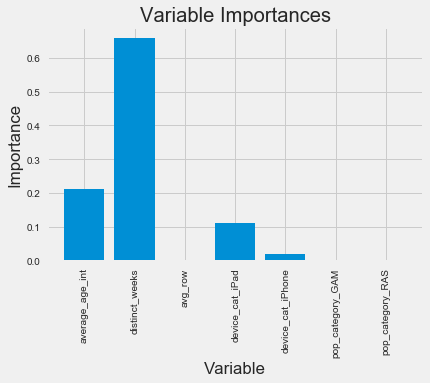

In [29]:
# Visualize variable importances 

%matplotlib inline
feature_list = X.columns

plt.style.use('fivethirtyeight')
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [31]:
from sklearn.tree import export_graphviz
import pydot

# generates trees, can visualize .dot file on www.webgraphviz.com
rf_small = clf
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[7]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1, class_names = ['0','1'])
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
#graph.write_png('small_tree.png')

/Users/christinejiang/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


## Unused test code - group different lesson categories by title, pairplots

In [55]:
# # initializes category grouping process, use "buzzwords"
# def init_buzzwords(attribute):
# 	desc = titles[[attribute]]
# 	description = attribute
# 	if attribute == 'dfox_keywords':
# 		buzzwords = top_keywords(desc)
# 	else:
# 		buzzwords = find_buzzwords(desc, description)
# 	return buzzwords

In [56]:
# def find_buzzwords(df, attribute):

# 	# declaring the nltk english stopwords list
# 	stopset = set(stopwords.words('english'))
# 	print "HELLO" + attribute + "\n" 
# 	df[attribute] = df[attribute].fillna(" ")

# 	# df[attribute] = df[attribute].apply(lambda x: str(x).encode('utf-8'))
# 	df[attribute] = df[attribute].apply(lambda x: repr(x).encode("utf-8"))
# 	df[attribute] = df[attribute].apply(lambda x: str(x).lower())
# 	full_set = []

# 	for desc in df[attribute]:
# 		desc = nltk.sent_tokenize(desc.decode('utf-8'))
# 		# tokenize the description ie. convert sentence into words (tokens)
# 		tokens = word_tokenize(str(desc))
# 		# remove stopwords from the tokens list
# 		tokens = [w for w in tokens if not w in stopset]
# 		# nltk tokens have "tags" for their "part of speech", ie. nouns, adjectives, verbs
# 		tags = nltk.pos_tag(tokens)
# 		# buzzwords is a list of nouns, adjectives and gerunds
# 		buzzwords = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos == 'VBG' or pos == 'JJ')]        
# 		full_set += buzzwords

# 	# removing some dirty data and redundant words that occur in top 50
# 	full_set = [word for word in full_set if word not in ['[', ']', '/', 'a','z','0', "u'0"]]
# 	new_set = pd.DataFrame(full_set).replace('\\', ' ')
# 	new_set2 = pd.DataFrame(new_set).replace('/', ' ')
# 	print new_set2
# 	# picking top 50
# 	top_50_set = pd.DataFrame(Counter(full_set).most_common(50), columns=['word', 'freq']).set_index('word')
# 	top_50_set = top_50_set.reset_index()
	
# 	#return top_50_set['word']
# 	return new_set2

In [57]:
# testing = buzzwords[0].map(lambda x: x.lstrip("\'").rstrip('aAbBcC'))
# testing.head(100)

In [58]:
# # Create columns of seasons for pair plotting colors
# seasons = []
# for age in X['average_age_int']:
#     if age in [0,1,2]:
#         seasons.append('young')
#     elif age in [3,4,5]:
#         seasons.append('med')
#     elif age in [6,7]:
#         seasons.append('old')
#     elif age in [8,9]:
#         seasons.append('oldest')
#     elif age is null:
#         seasons.append('null')
# # Will only use six variables for plotting pairs
# reduced_features = X
# reduced_features['ages'] = seasons
# # Use seaborn for pair plots
# import seaborn as sns
# sns.set(style="ticks", color_codes=True);
# # Create a custom color palete
# palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])
# # Make the pair plot with a some aesthetic changes
# sns.pairplot(reduced_features, hue = 'ages', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
#                    diag_kws=dict(shade=True))